# Wasserstein GANS (46%)

In [1]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=20, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.00005, help="learning rate")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
opt = parser.parse_args([])
print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False


Namespace(batch_size=64, channels=1, clip_value=0.01, img_size=28, latent_dim=100, lr=5e-05, n_cpu=8, n_critic=5, n_epochs=20, sample_interval=400)


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


## a) Train your model on the data set (33%)
We have used "Gradient Penalty" referring https://discuss.pytorch.org/t/how-to-implement-gradient-penalty-in-pytorch/1656

In [3]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=opt.lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=opt.lr)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

batches_done = 0
for epoch in range(opt.n_epochs):

    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z).detach()

        # Adversarial loss
        loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))

        loss_D.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-opt.clip_value, opt.clip_value)

        # Train the generator every n_critic iterations
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z)
            
            # Adversarial loss
            loss_G = -torch.mean(discriminator(gen_imgs))

            loss_G.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, opt.n_epochs, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
            )

        if batches_done % opt.sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
        batches_done += 1

Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw


Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw


Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


[Epoch 0/20] [Batch 0/938] [D loss: 0.015077] [G loss: -0.001440]

[Epoch 0/20] [Batch 5/938] [D loss: -0.108537] [G loss: -0.002060]
[Epoch 0/20] [Batch 10/938] [D loss: -0.365144] [G loss: -0.005063]
[Epoch 0/20] [Batch 15/938] [D loss: -0.763189] [G loss: -0.016339]
[Epoch 0/20] [Batch 20/938] [D loss: -1.295304] [G loss: -0.042762]
[Epoch 0/20] [Batch 25/938] [D loss: -1.865620] [G loss: -0.083377]
[Epoch 0/20] [Batch 30/938] [D loss: -2.508954] [G loss: -0.141541]
[Epoch 0/20] [Batch 35/938] [D loss: -3.106123] [G loss: -0.218953]
[Epoch 0/20] [Batch 40/938] [D loss: -3.779130] [G loss: -0.322846]
[Epoch 0/20] [Batch 45/938] [D loss: -4.488727] [G loss: -0.457861]
[Epoch 0/20] [Batch 50/938] [D loss: -5.119602] [G loss: -0.594313]
[Epoch 0/20] [Batch 55/938] [D loss: -5.725089] [G loss: -0.770096]
[Epoch 0/20] [Batch 60/938] [D loss: -6.150035] [G loss: -0.997984]
[Epoch 0/20] [Batch 65/938] [D loss: -6.764479] [G loss: -1.209038]
[Epoch 0/20] [Batch 70/938] [D loss: -7.327987] [G

In [4]:
def show_image(reconsPath):
  Image = mpimg.imread(reconsPath)
  plt.imshow(Image) 
  plt.axis('off') 
  plt.show()

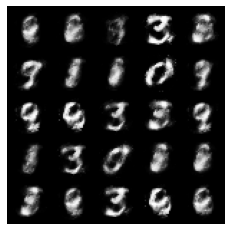

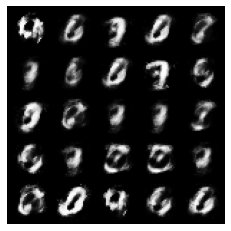

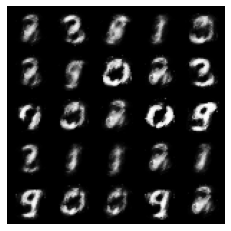

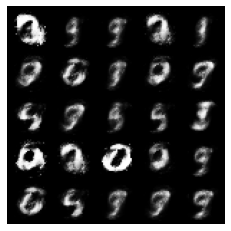

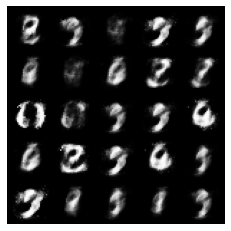

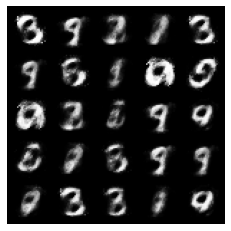

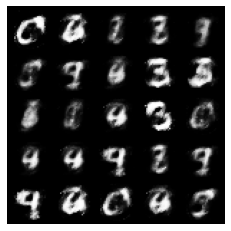

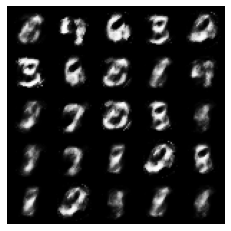

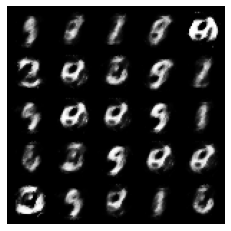

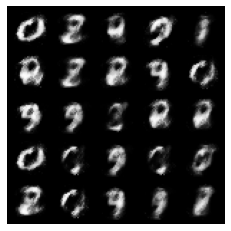

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

for i in range(14000, 18000, 400):
  reconsPath = './images/%d.png' %i
  show_image(reconsPath)